In [ ]:
%pip install -q requests matplotlib
%matplotlib inline

In [ ]:
import requests
import datetime
import matplotlib.pyplot as plt

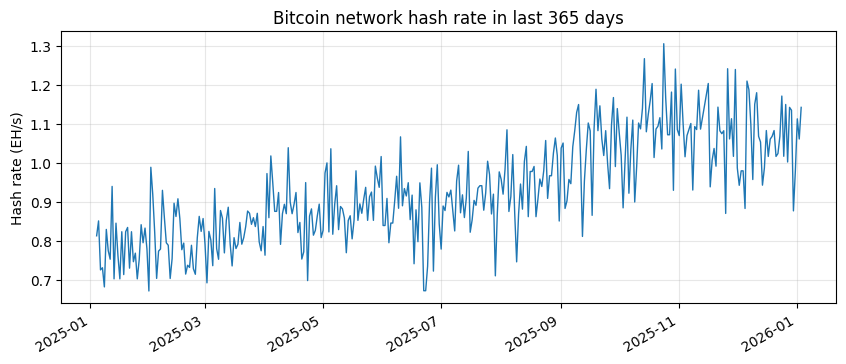

In [ ]:
API = "https://api.blockchain.info/charts/hash-rate"
r_365 = requests.get(API, params={"timespan":"365days","format":"json"}, timeout=15)
r_1 = requests.get(API, params={"timespan":"1days","format":"json"}, timeout=15)
js = r.json()
UNIT = js.get("unit", "GH/s")
MULT = {"H/s":1,"KH/s":1e3,"MH/s":1e6,"GH/s":1e9,"TH/s":1e12,"PH/s":1e15,"EH/s":1e18}.get(UNIT, 1e9)

xs = [datetime.datetime.fromtimestamp(v["x"]) for v in js["values"]]
ys = [v["y"] * MULT for v in js["values"]]

plt.figure(figsize=(10,4))
plt.plot(xs, [y/1e18 for y in ys], lw=1)
plt.ylabel("Hash rate (EH/s)")
plt.title("Bitcoin network hash rate in last 365 days")
plt.grid(alpha=0.3)
plt.gcf().autofmt_xdate()
plt.show()